# CS 228 Final Project
## Enhancing Image Captioning with Deep Learning Models
### Saul Gonzalez - sgonz081
### Shaheriar Malik - smali032

Dataset: https://www.kaggle.com/datasets/hsankesara/flickr-image-dataset

Image captioning is a difficult task that is one step above image classification since we are
generating an actual text description of each image. So, deep learning would be an obvious choice in this case since generating text for a variable input image is a difficult task that would require a complex model.


In [15]:
import torch
import torchvision.models as models
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision import datasets
from torch.utils.data import Dataset, DataLoader
from torchtext.data import get_tokenizer
from torchtext.vocab import vocab
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import random_split
from copy import deepcopy

from PIL import Image
import nltk

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from google.colab import drive

import random
import os
import natsort
import cv2
from collections import Counter, OrderedDict

from textwrap import wrap
from IPython.display import clear_output

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [16]:
!unzip "/content/drive/My Drive/ImageCaptioningDataset/flickr30k_images.zip" -d "/content"
clear_output()

In [17]:
raw_df = pd.read_csv('/content/drive/MyDrive/ImageCaptioningDataset/results.csv', sep='|', header = None)
#raw_df.drop([' comment_number'],axis=1, inplace=True)
#raw_df.columns = raw_df.columns.str.replace(' ', '')
#raw_df.loc[19999,'comment'] = 'A dog runs across the grass .'
#raw_df.to_csv('out.csv',sep='|',index=False)
#raw_df.iloc[[19999]]

In [18]:
# read, resize and zero pad images. Returns image tensor [3, 256, 256]
def readImage(path):
    desired_size = 256 # 256 x 256
    image = cv2.imread(path)
    old_size = image.shape[:2]
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    ratio = float(desired_size)/max(old_size)
    new_size = tuple([int(x*ratio) for x in old_size])
    image = cv2.resize(image, (new_size[1], new_size[0]))
    delta_w = desired_size - new_size[1]
    delta_h = desired_size - new_size[0]
    top, bottom = delta_h//2, delta_h-(delta_h//2)
    left, right = delta_w//2, delta_w-(delta_w//2)
    new_im = cv2.copyMakeBorder(image, top, bottom, left, right, cv2.BORDER_CONSTANT, value=[0, 0, 0])
    transform = transforms.ToTensor()
    tensor = transform(new_im)
    return tensor

def display_images(temp_df):
    temp_df = temp_df.reset_index(drop=True)
    num = temp_df.shape[0]
    plt.figure(figsize = (20 , 20))
    n = 0
    for i in range(num):
        n+=1
        plt.subplot(5 , 5, n)
        plt.subplots_adjust(hspace = 0.1, wspace = 0.1)
        image = readImage(f"/content/flickr30k_images/{temp_df.image_name[i]}")
        plt.imshow(image.permute(1, 2, 0))
        plt.title("\n".join(wrap(temp_df.comment[i], 30)))

#num = 5
#display_images(raw_df.sample(num))

In [19]:
# Build vocabulary for Captions
def build_vocab(captions,tokenizer,max_len):
  counter = Counter()
  current_max = max_len
  for caption in captions:
    sentence = caption.strip()
    tokens = tokenizer(sentence)
    if len(tokens) > current_max:
      current_max = len(tokens)
    counter.update(tokens)
  sorted_by_freq = sorted(counter.items(), key=lambda x: x[1], reverse=True)
  dictionary = OrderedDict(sorted_by_freq)
  dictionary = dict(dictionary)
  dictionary['<PAD>'] = len(dictionary)
  # dictionary['SOS'] = len(dictionary) + 1
  # dictionary['EOS'] = len(dictionary) + 2
  # dictionary['<UNK>'] = len(dictionary) + 3
  dictionary = OrderedDict(dictionary)
  return vocab(dictionary), current_max

In [20]:
class CustomDataset(Dataset):
    def __init__(self, data_dir, label_csv, transform=None):
        self.data_dir = data_dir
        self.target_len = -1

        self.data_df = pd.read_csv(label_csv, sep='|',header=None)
        self.data_df = self.data_df.dropna()
        #self.data_df.drop([' comment_number'],axis=1, inplace=True)
        #self.data_df.columns = self.data_df.columns.str.replace(' ', '')
        self.captions = self.data_df[1] # 0 is image_name, 1 is comment

        self.transform = transform
        self.image_paths = self.data_df[0]#os.listdir(data_dir)  # Assumes images are directly under data_dir

        self.tokenizer = get_tokenizer("basic_english")
        self.vocab, self.target_len = build_vocab(self.captions.tolist(),self.tokenizer,self.target_len)

    def __len__(self):
        return len(self.data_df)

    def __getitem__(self, idx):
        image_path = os.path.join(self.data_dir, self.image_paths[idx])
        #image = cv2.imread(image_path)
        #image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        desired_size = 128 # 128x128
        image = cv2.imread(image_path)
        old_size = image.shape[:2]
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = (image - np.mean(image))/np.std(image) # normalize
        ratio = float(desired_size)/max(old_size)
        new_size = tuple([int(x*ratio) for x in old_size])
        image = cv2.resize(image, (new_size[1], new_size[0]))
        delta_w = desired_size - new_size[1]
        delta_h = desired_size - new_size[0]
        top, bottom = delta_h//2, delta_h-(delta_h//2)
        left, right = delta_w//2, delta_w-(delta_w//2)
        new_im = cv2.copyMakeBorder(image, top, bottom, left, right, cv2.BORDER_CONSTANT, value=[0, 0, 0])
        transform = transforms.ToTensor()
        tensor = transform(new_im)
        #image = tensor.ToPILImage()
        image = tensor
        #image = Image.open(image_path).convert("RGB")
        caption = self.captions[idx]
        
        #if self.transform is not None:
        #    image = self.transform(image)

        # Vectorize the given caption using our dataset's vocabulary
        caption = caption.strip()
        caption = self.tokenizer(caption)
        caption_vector = [self.vocab[word] for word in caption]

        # Add padding to the vector if it needs it
        if len(caption_vector) < self.target_len:
          for i in range(self.target_len - len(caption_vector)):
            caption_vector.append(self.vocab['<PAD>'])

        # Return the processed image and any associated labels
        return image, torch.tensor(caption_vector)


In [21]:
transform = transforms.Compose([
    #transforms.Resize((128, 128)),
    transforms.ToPILImage()
])

data_dir = '/content/flickr30k_images/'
label_csv = '/content/drive/MyDrive/ImageCaptioningDataset/results.csv'
dataset = CustomDataset(data_dir, label_csv, transform=transform)
len(dataset)

158915

In [22]:
test,train = random_split(dataset, [int(len(dataset)*0.3)+1, int(len(dataset)*0.7)])
print(len(test),len(train))

47675 111240


In [23]:
image_paths = raw_df[0]
image_paths[0]

'1000092795.jpg'

In [24]:
batch_size = 37
#dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
train_loader = DataLoader(train, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test, batch_size=batch_size, shuffle=False)

In [25]:
# import time
# i = 0
# for img, file_name in dataloader:
#   clear_output()
#   #print(label[0])
#   #print(raw_df['image_name'])
#   plt.imshow(img[0].permute(1,2,0))
#   print(list(raw_df.loc[raw_df['image_name'] == file_name[0]].comment)[0])
#   i+=5
#   plt.show()
#   time.sleep(1)

## Convolutional Neual Network (CNN)

In [26]:
vocab_size = len(dataset.vocab)
vocab_size

20217

In [27]:
class ImageCaptioningModel(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size):
        super(ImageCaptioningModel, self).__init__()
        
        # Load the pretrained ResNet-101 model
        self.resnet = models.wide_resnet50_2(weights=None)
        self.resnet.fc = nn.Linear(2048, embed_size)
        
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTM(embed_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, vocab_size)

    def forward(self, images, captions):
        features = self.resnet(images)
        features = features.unsqueeze(1)
        
        embeddings = self.embedding(captions)
        
        combined = torch.cat((features, embeddings), dim=1)
        
        lstm_out, _ = self.lstm(combined)
        
        outputs = self.fc(lstm_out)
        
        return outputs

In [28]:
embed_size = 256  # Size of the word embedding
hidden_size = 512  # Size of the LSTM hidden state

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device('mps') if torch.backends.mps.is_available() else device

model = ImageCaptioningModel(embed_size, hidden_size, vocab_size).to(device)

In [29]:
def mixup(x, y, a):
    lam = np.random.beta(a,a)
    rand = torch.randperm(batch_size)
    x2 = x[rand,:]
    y2 = y[rand,:]
    X = lam * x + (1 - lam) * x2
    Y = lam * y + (1 - lam) * y2
    print(Y)
    return X, Y

def cutout(image, k):
    x = np.random.randint(0, 128-k)
    y = np.random.randint(0, 128-k)
    image[:, x:x+k, y:y+k] = 0
    return image

def standard_augmentation(image,k):
    k1 = np.random.randint(-k, k)
    k2 = np.random.randint(-k, k)
    image = np.roll(image, k1, axis=1)
    image = np.roll(image, k2, axis=2)
    if (k1 > 0):    
        image[:, :k1, :] = 0
    else:
        image[:, k1:, :] = 0
    if (k2 > 0):
        image[:, :, :k2] = 0
    else:
        image[:, :, k2:] = 0
    if (np.random.rand() < 0.5):
        image = np.flip(image, axis=2)
    return image

In [30]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
num_epochs = 10

def training():
  for epoch in range(num_epochs):
      i = 0
      copy_train_loader = deepcopy(train_loader)
      for images, captions in copy_train_loader:
          # Move images and captions to device (e.g., GPU)
          #if (np.random.rand() < 0.5):
                #image = X_epoch[j].cpu()
                #X_epoch[j] = cutout(image, 16)
              #image = X_epoch[j].cpu()
              #X_epoch[j] = torch.from_numpy(standard_augmentation(image, 4).copy()).to(device)
            #X_epoch, Y_epoch = mixup(X_epoch, Y_epoch, alpha)
          images = images.to(device, dtype=torch.float)
          for j in range(len(images)):
            if (np.random.rand() < 0.5):
              images[j] = cutout(images[j], 64)
            images[j] = torch.from_numpy(standard_augmentation(images[j].cpu(),16).copy())
          #images, captions = mixup(images, captions, 0.4)

          captions = captions.to(device)

          # Forward pass
          outputs = model(images, captions[:, :-1])

          # Reshape captions for loss calculation
          targets = captions[:, :].reshape(-1)
          
          # Compute loss
          loss = criterion(outputs.reshape(-1, vocab_size), targets)

          # Backward pass and optimization
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()

          # Print the loss
          if i % 100 == 0:
            print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, i, len(train_loader), loss.item()))
          i+=1

#model.load_state_dict(torch.load('/content/drive/MyDrive/ImageCaptioningDataset/model_path.pt'), strict=False)
training()

Epoch [1/10], Step [0/3007], Loss: 9.9930
Epoch [1/10], Step [100/3007], Loss: 0.8678
Epoch [1/10], Step [200/3007], Loss: 0.8018
Epoch [1/10], Step [300/3007], Loss: 0.7149
Epoch [1/10], Step [400/3007], Loss: 0.7411
Epoch [1/10], Step [500/3007], Loss: 0.7631
Epoch [1/10], Step [600/3007], Loss: 0.6593
Epoch [1/10], Step [700/3007], Loss: 0.6717
Epoch [1/10], Step [800/3007], Loss: 0.5784
Epoch [1/10], Step [900/3007], Loss: 0.6325
Epoch [1/10], Step [1000/3007], Loss: 0.5740
Epoch [1/10], Step [1100/3007], Loss: 0.6292
Epoch [1/10], Step [1200/3007], Loss: 0.7232
Epoch [1/10], Step [1300/3007], Loss: 0.5965
Epoch [1/10], Step [1400/3007], Loss: 0.6151
Epoch [1/10], Step [1500/3007], Loss: 0.6807
Epoch [1/10], Step [1600/3007], Loss: 0.5467
Epoch [1/10], Step [1700/3007], Loss: 0.6551
Epoch [1/10], Step [1800/3007], Loss: 0.6922
Epoch [1/10], Step [1900/3007], Loss: 0.6429
Epoch [1/10], Step [2000/3007], Loss: 0.6458
Epoch [1/10], Step [2100/3007], Loss: 0.6074
Epoch [1/10], Step [22

In [33]:
normal_image = dataset[0][0]
image = dataset[0][0].unsqueeze(0)
caption = dataset[0][1].unsqueeze(0)
image = image.to(device, dtype=torch.float)
caption = caption.to(device)

In [34]:
model.eval()
with torch.no_grad():
  outputs = model(image,caption)
  _,preds = torch.max(outputs,2)

In [35]:
translated_preds = []
for _,num in enumerate(preds[0]):
  idx = num.item()
  if idx != 20216:
    translated_preds.append(dataset.vocab.lookup_token(idx))

pred_caption = ' '.join(translated_preds)
print(pred_caption)

a people boys are goatees , and at each faces and walking from in a street .


a people boys are goatees , and at each faces and walking from in a street .


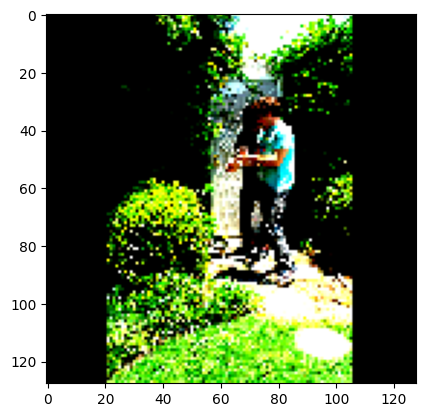

In [36]:
plt.figure()
plt.imshow(normal_image.permute(1, 2, 0))
print(pred_caption)

In [37]:
torch.save(model.state_dict(), '/content/drive/MyDrive/ImageCaptioningDataset/model.pt')